# VISION AND PERCEPTION PROJECT
**Continual Learning Applied on Colorectal Histology Image Data**

**Mert YILDIZ**

**1951070**

##Import All Libraries

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tqdm import tqdm
from tensorflow import keras
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, ReLU,  Flatten , Dense,Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras import backend as k
from keras.utils.vis_utils import plot_model
import time
import random
random.seed(42)

## Download Dataset

In [2]:
(training_set, validation_set, test_set), dataset_info = tfds.load(
    'colorectal_histology',
    split=['train[:70%]', 'train[70%:85%]','train[85%:]'],
    with_info=True,
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteHBRPOI/colorectal_histology-train.tfr…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


## Exploratory Data Analysis

In [3]:
# Check amount of samples in each set
print('Number of Samples in ')
print()
print('Training Set:',len(training_set))
print('Validation Set:',len(validation_set))
print('Test Set:',len(test_set))

Number of Samples in 

Training Set: 3500
Validation Set: 750
Test Set: 750


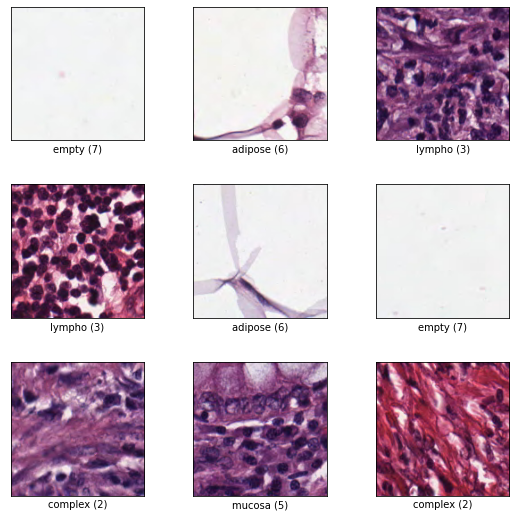

In [4]:
# Visualize some random sample from the dataset
fig = tfds.show_examples(test_set, dataset_info)

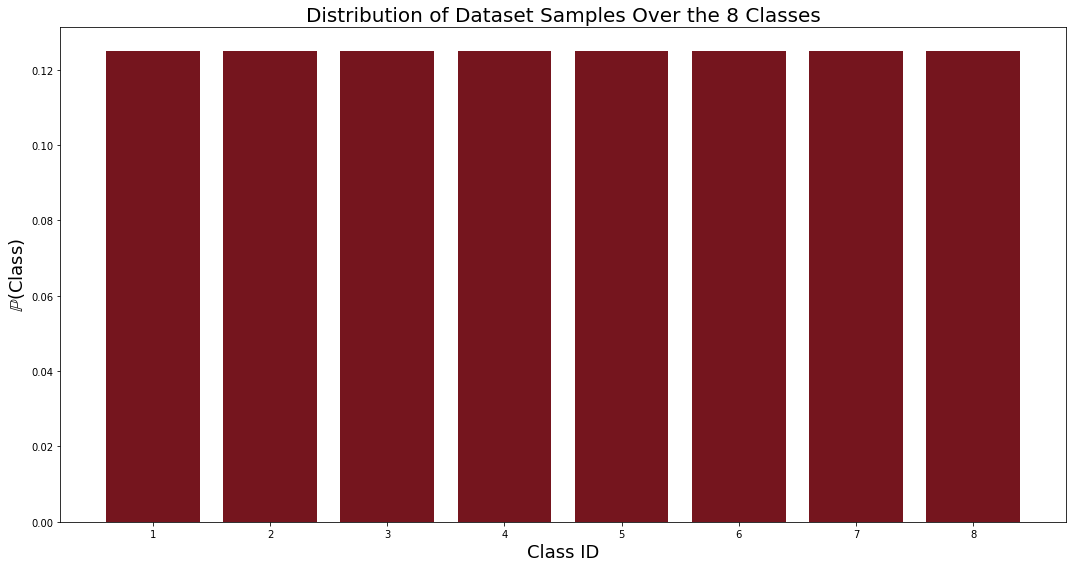

In [5]:
# Check the labels and append them to the list to check their distribution 

number_of_classes=np.zeros(8)

for item in training_set:
  number_of_classes[item[1].numpy()]+=1
for item in validation_set:
  number_of_classes[item[1].numpy()]+=1
for item in test_set:
  number_of_classes[item[1].numpy()]+=1
num_classes=number_of_classes/np.sum(number_of_classes)

plt.figure(figsize=(15,8),tight_layout=True)
plt.style.use('seaborn-deep')
plt.title((r'Distribution of Dataset Samples Over the 8 Classes'),fontsize=20)
plt.xlabel((r'Class ID'),fontsize=18)
plt.ylabel((r'$\mathbb{P}$(Class)'),fontsize=18)
plt.bar(np.arange(1,9),num_classes, label=r'$\alpha_s$',color='#75151e')
plt.show()

## Model

## Without Regularization

In [6]:
# Define the CNN with the Sequential API
model = Sequential()

# 1st block
model.add(Conv2D(128, kernel_size=(3, 3),strides=(1, 1),input_shape=(150, 150,3),activation="linear",padding='same'))
model.add(MaxPooling2D((5, 5),padding='valid'))
model.add(ReLU())

# 2nd block
model.add(Conv2D(128, (3, 3),strides=(1, 1), activation='linear',padding='same'))
model.add(MaxPooling2D((5, 5),padding='valid'))
model.add(ReLU())

# 3rd block
model.add(Conv2D(128, (3, 3),strides=(1, 1), activation='linear',padding='same'))
model.add(MaxPooling2D((6, 6),padding='valid'))
model.add(ReLU())

# Dense classifier
model.add(Flatten())
model.add(Dense(128, activation='linear'))
model.add(ReLU())
model.add(Dense(8, activation='softmax'))

In [7]:
# Initialize selected loss function and optimizer
cross_entropy = tf.losses.SparseCategoricalCrossentropy()
adam = tf.optimizers.Adam()

# Initialize chosen callback
mcp_save = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

# Compile the model
model.compile(loss=cross_entropy, optimizer=adam,metrics=["accuracy"])

# Number of epochs and batch size
BATCH_SIZE = 32
EPOCHS = 20

# Define the function to normalize pixel values in the range [0,1]
def pixel_normalizer(x,y):
  return x/255,y

train=training_set.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer).prefetch(tf.data.AUTOTUNE)
valid=validation_set.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer).prefetch(tf.data.AUTOTUNE)
test=test_set.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer).prefetch(tf.data.AUTOTUNE)

# Fit the model and train
conv_train=model.fit(
    train, 
    epochs=EPOCHS,
    validation_data=valid,
    callbacks=[mcp_save])


Epoch 1/20
110/110 [==============================] - 13s 41ms/step - loss: 1.3443 - accuracy: 0.4437 - val_loss: 0.7629 - val_accuracy: 0.7213
Epoch 2/20
110/110 [==============================] - 4s 36ms/step - loss: 0.7995 - accuracy: 0.6720 - val_loss: 0.7585 - val_accuracy: 0.7240
Epoch 3/20
110/110 [==============================] - 4s 38ms/step - loss: 0.6701 - accuracy: 0.7520 - val_loss: 0.8104 - val_accuracy: 0.6493
Epoch 4/20
110/110 [==============================] - 4s 35ms/step - loss: 0.6173 - accuracy: 0.7669 - val_loss: 0.8214 - val_accuracy: 0.6773
Epoch 5/20
110/110 [==============================] - 4s 36ms/step - loss: 0.5725 - accuracy: 0.7786 - val_loss: 0.5204 - val_accuracy: 0.8320
Epoch 6/20
110/110 [==============================] - 4s 36ms/step - loss: 0.5451 - accuracy: 0.8031 - val_loss: 0.5192 - val_accuracy: 0.8227
Epoch 7/20
110/110 [==============================] - 4s 36ms/step - loss: 0.4727 - accuracy: 0.8214 - val_loss: 0.5117 - val_accuracy: 0.805

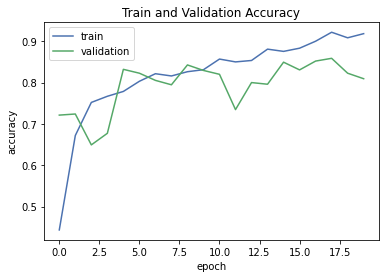

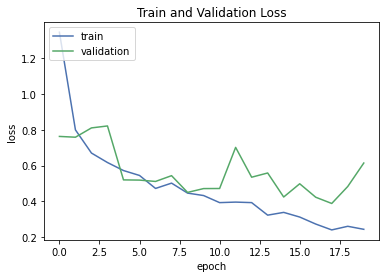

In [8]:
# Plot loss and accuracy trends both on the training and validation set.
# "Accuracy"
plt.plot(conv_train.history['accuracy'])
plt.plot(conv_train.history['val_accuracy'])
plt.title('Train and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(conv_train.history['loss'])
plt.plot(conv_train.history['val_loss'])
plt.title('Train and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [9]:
# Load best model
model.load_weights('best_model.hdf5')

# Evaluate model performances on top of the test set..
results = model.evaluate(test)
print("\nTest loss: ",np.round(results[0],4),"\nTest accuracy: ", np.round(results[1],4))

24/24 [==============================] - 0s 18ms/step - loss: 0.4193 - accuracy: 0.8360

Test loss:  0.4193 
Test accuracy:  0.836



## With Dropout as Regularization

In [10]:
p = 0.3
# Define out own CNN with the Sequential API
model = Sequential()

# 1st block
model.add(Conv2D(128, kernel_size=(3, 3),strides=(1, 1),input_shape=(150,150,3),activation="linear",padding='same'))
model.add(Dropout(p))
model.add(MaxPooling2D((5, 5),padding='valid'))
model.add(ReLU())

# 2nd block
model.add(Conv2D(512, (3, 3),strides=(1, 1), activation='linear',padding='same'))
model.add(Dropout(p))
model.add(MaxPooling2D((5, 5),padding='valid'))
model.add(ReLU())

# 3rd block
model.add(Conv2D(512, (3, 3),strides=(1, 1), activation='linear',padding='same'))
model.add(Dropout(p))
model.add(MaxPooling2D((6, 6),padding='valid'))
model.add(ReLU())

# Dense classifier
model.add(Flatten())
model.add(Dense(512, activation='linear'))
model.add(Dropout(p))
model.add(ReLU())
model.add(Dense(8, activation='softmax'))

# Initialize selected loss function and optimizer
cross_entropy = tf.losses.SparseCategoricalCrossentropy()
adam = tf.optimizers.Adam()

# Initialize chosen callback
earlyStopping = EarlyStopping(monitor='val_loss', patience=7, verbose=0, mode='min',restore_best_weights=True)
mcp_save = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

# Compile the model
model.compile(loss=cross_entropy, optimizer=adam,metrics=["accuracy"])

#Build the data pipelines
train=training_set.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer).prefetch(tf.data.AUTOTUNE)
valid=validation_set.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer).prefetch(tf.data.AUTOTUNE)
test=test_set.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer).prefetch(tf.data.AUTOTUNE)

# Fit the model and train
conv_train=model.fit(
    train, 
    epochs=EPOCHS,
    validation_data=valid,
    callbacks=[earlyStopping, mcp_save])

Epoch 1/20
110/110 [==============================] - 10s 81ms/step - loss: 1.2483 - accuracy: 0.4651 - val_loss: 1.1335 - val_accuracy: 0.6093
Epoch 2/20
110/110 [==============================] - 8s 76ms/step - loss: 0.7757 - accuracy: 0.6929 - val_loss: 1.0171 - val_accuracy: 0.6280
Epoch 3/20
110/110 [==============================] - 8s 76ms/step - loss: 0.6698 - accuracy: 0.7469 - val_loss: 0.8307 - val_accuracy: 0.7600
Epoch 4/20
110/110 [==============================] - 8s 75ms/step - loss: 0.6075 - accuracy: 0.7754 - val_loss: 0.9352 - val_accuracy: 0.7653
Epoch 5/20
110/110 [==============================] - 8s 76ms/step - loss: 0.5157 - accuracy: 0.8089 - val_loss: 0.7584 - val_accuracy: 0.7827
Epoch 6/20
110/110 [==============================] - 8s 75ms/step - loss: 0.4921 - accuracy: 0.8140 - val_loss: 0.8085 - val_accuracy: 0.7760
Epoch 7/20
110/110 [==============================] - 8s 76ms/step - loss: 0.4462 - accuracy: 0.8300 - val_loss: 0.7109 - val_accuracy: 0.814

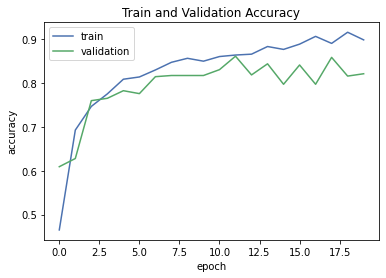

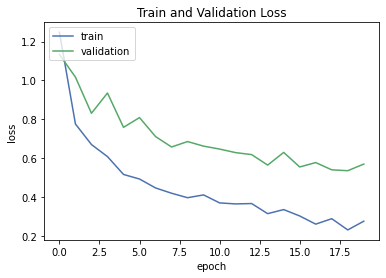

In [11]:
# Plot loss and accuracy trends both on the training and validation set.
# "Accuracy"
plt.plot(conv_train.history['accuracy'])
plt.plot(conv_train.history['val_accuracy'])
plt.title('Train and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(conv_train.history['loss'])
plt.plot(conv_train.history['val_loss'])
plt.title('Train and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [12]:
model.load_weights('best_model.hdf5')

results = model.evaluate(test)
print("\nTest loss: ",np.round(results[0],4),"\nTest accuracy: ", np.round(results[1],4))

24/24 [==============================] - 1s 21ms/step - loss: 0.5294 - accuracy: 0.8373

Test loss:  0.5294 
Test accuracy:  0.8373


## With L2 Regularization

In [13]:
L2 = 0.0005

# Define out own CNN with the Sequential API
model = Sequential()

# 1st block
model.add(Conv2D(128, kernel_size=(3, 3),strides=(1, 1),input_shape=(150,150,3),activation="linear",padding='same',kernel_regularizer=tf.keras.regularizers.l2(L2)))
model.add(MaxPooling2D((5, 5),padding='valid'))
model.add(ReLU())

# 2nd block
model.add(Conv2D(256, (3, 3),strides=(1, 1), activation='linear',padding='same',kernel_regularizer=tf.keras.regularizers.l2(L2)))
model.add(MaxPooling2D((5, 5),padding='valid'))
model.add(ReLU())

# 3rd block
model.add(Conv2D(256, (3, 3),strides=(1, 1), activation='linear',padding='same',kernel_regularizer=tf.keras.regularizers.l2(L2)))
model.add(MaxPooling2D((6, 6),padding='valid'))
model.add(ReLU())

# Dense classifier
model.add(Flatten())
model.add(Dense(256, activation='linear',kernel_regularizer=tf.keras.regularizers.l2(L2)))
model.add(ReLU())
model.add(Dense(8, activation='softmax'))

# Initialize selected loss function and optimizer
cross_entropy = tf.losses.SparseCategoricalCrossentropy()
adam = tf.optimizers.Adam()

# Initialize chosen callback
mcp_save = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

# Compile the model
model.compile(loss=cross_entropy, optimizer=adam,metrics=["accuracy"])

#Build the data pipelines
train=training_set.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer).prefetch(tf.data.AUTOTUNE)
valid=validation_set.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer).prefetch(tf.data.AUTOTUNE)
test=test_set.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer).prefetch(tf.data.AUTOTUNE)

# Fit the model and train
conv_train=model.fit(
    train, 
    epochs=EPOCHS,
    validation_data=valid,
    callbacks=[mcp_save])

Epoch 1/20
110/110 [==============================] - 6s 44ms/step - loss: 1.4743 - accuracy: 0.4689 - val_loss: 1.0451 - val_accuracy: 0.6253
Epoch 2/20
110/110 [==============================] - 5s 41ms/step - loss: 0.9394 - accuracy: 0.6669 - val_loss: 0.7702 - val_accuracy: 0.7467
Epoch 3/20
110/110 [==============================] - 4s 41ms/step - loss: 0.7888 - accuracy: 0.7426 - val_loss: 0.6853 - val_accuracy: 0.7853
Epoch 4/20
110/110 [==============================] - 4s 40ms/step - loss: 0.7163 - accuracy: 0.7751 - val_loss: 0.7451 - val_accuracy: 0.7827
Epoch 5/20
110/110 [==============================] - 4s 40ms/step - loss: 0.6897 - accuracy: 0.7880 - val_loss: 0.6607 - val_accuracy: 0.7827
Epoch 6/20
110/110 [==============================] - 4s 40ms/step - loss: 0.7221 - accuracy: 0.7714 - val_loss: 0.6214 - val_accuracy: 0.8080
Epoch 7/20
110/110 [==============================] - 4s 40ms/step - loss: 0.6104 - accuracy: 0.8169 - val_loss: 0.6678 - val_accuracy: 0.7813

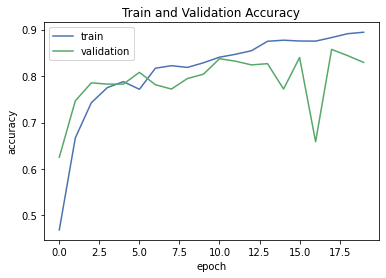

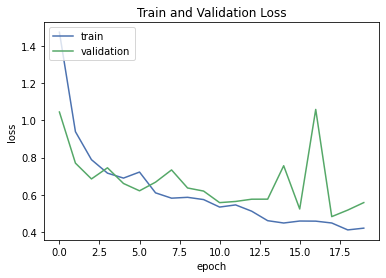

In [14]:
# Plot loss and accuracy trends both on the training and validation set.
# "Accuracy"
plt.plot(conv_train.history['accuracy'])
plt.plot(conv_train.history['val_accuracy'])
plt.title('Train and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(conv_train.history['loss'])
plt.plot(conv_train.history['val_loss'])
plt.title('Train and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
model.load_weights('best_model.hdf5')

results = model.evaluate(test)
print("\nTest loss: ",np.round(results[0],4),"\nTest accuracy: ", np.round(results[1],4))

24/24 [==============================] - 0s 18ms/step - loss: 0.4801 - accuracy: 0.8560

Test loss:  0.4801 
Test accuracy:  0.856


## Continual Learning

In [16]:
# As our labels are from {1 - 8} so when we are going to use sparsecategorical crossentropy, we need them to be {0,1} scale
def normalize_pixels_scale_labels(x,y,scale):
  return x/255,y-scale

# Split the dataset to 4 tasks
def splitting_tasks(dataset,num_tasks):
  return [dataset.filter(lambda text, label: label == i) for i in range(num_tasks)] 

num_classes=8
num_tasks = 4

train_data = splitting_tasks(training_set,num_classes)
valid_data = splitting_tasks(validation_set,num_classes)
test_data = splitting_tasks(test_set,num_classes)

In [17]:
# Define multi-head architecture
input = keras.Input(shape=(150, 150, 3), name="image")

# 1st Block
x = Conv2D(128, kernel_size=(3, 3),strides=(1, 1),input_shape=(64,64,3),activation="linear",padding='same',name="2DConv_1")(input)
x = MaxPooling2D((5, 5),padding='valid',name="2DMaxpool_1")(x)
x = ReLU(name="Relu_1")(x)

# 2nd Block
x = Conv2D(128, kernel_size=(3, 3),strides=(1, 1),activation="linear",padding='same',name="2DConv_2")(x)
x = MaxPooling2D((5, 5),padding='valid',name="2DMaxpool_2")(x)
x = ReLU(name="Relu_2")(x)

# 3rd Block
x = Conv2D(128, kernel_size=(3, 3),strides=(1, 1),activation="linear",padding='same',name="2DConv_3")(x)
x = MaxPooling2D((6, 6),padding='valid',name="2DMaxpool_3")(x)
x = ReLU(name="Relu_3")(x)

# Dense Classifier
x = Flatten(name="Flatten")(x)
x = Dense(128, activation='linear',name="Final_Dense")(x)

# Multiple Heads
head_0=Dense(2, activation='softmax',name="head_0")(x)
head_1=Dense(2, activation='softmax',name="head_1")(x)
head_2=Dense(2, activation='softmax',name="head_2")(x)
head_3=Dense(2, activation='softmax',name="head_3")(x)

mul_head = keras.Model(inputs=input, outputs=[head_0,head_1,head_2,head_3], name="Multiple_Head_Model")

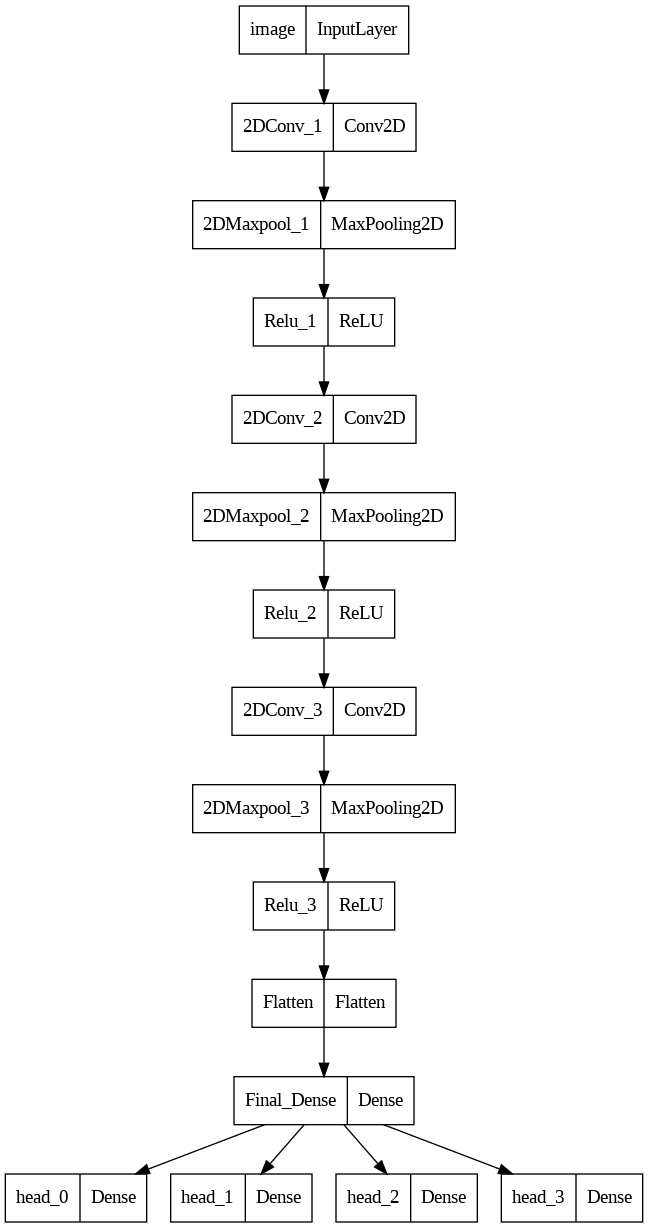

In [18]:
# Plot model
plot_model(mul_head)

**In here to calculate the fisher matrix as per the research I have done mostly the paper given below was pointed and I have just tried to change but it would still be the same since the calculation is the same but I have adapted to my case.**

https://seanmoriarity.com/2020/10/18/continual-learning-with-ewc/

In [19]:
# Define the function to compute Fisher matrix
def compute_fisher_matrix(model, task_set, batch_size,task_id):

  # Build fisher matrixes dictionary: at each key it will store the Fisher matrix for a particular layer
  fisher_matrixes = {n: tf.zeros_like(p.value()) for n, p in enumerate(model.trainable_variables)}
 
  for i, (imgs, labels) in enumerate(task_set.take(batch_size)):
    # Initialize gradients storage
    with tf.GradientTape() as tape:

      # Compute the predictions (recall: we will just take the prediction from the head related to the actual task)
      preds = model(imgs)[task_id]

      # Compute the logarithm of the predictions
      ll= tf.math.log(preds)

    # Attach gradients over the log_likelihood to log_likelihood_grads
    ll_grads  = tape.gradient(ll, model.trainable_variables)

    # Compute Fisher matrix at each layer (if existing)
    for i, gradients in enumerate(ll_grads):
      if gradients != None:
        fisher_matrixes[i] += tf.math.reduce_mean(gradients ** 2, axis=0) / batch_size
 
  return fisher_matrixes

# A wrapper has been used in the custom loss to send the old model parameters, the Fisher matrixes and the Lambda control value into the loss computation.
def EWC_loss(F,task_prev_param,Lambda): 

  def custom_loss(y_true, y_pred):
    # Compute standard cross entropy loss
    loss=tf.keras.losses.SparseCategoricalCrossentropy()
    normal_loss=loss(y_true,y_pred)

    # Compute EWC regularization term
    regularization_value=tf.constant([0.])
    for layer in range(len(F)):
      regularization_value+=tf.reduce_sum(F[layer]*(task_prev_param[layer]-mul_head.trainable_variables[layer])**2)

    # Return the standard cross entropy loss + EWC regularization
    return normal_loss+regularization_value*Lambda
  return custom_loss

# Define custom function to compute accuracy of the model for the test set
def check_test_acc(model,task,test_data,normalizer_scaler):
  counter=0
  correct=0
  scale=2*task

  for x,y in test_data[scale].concatenate(test_data[scale+1]).shuffle(1000).batch(1).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale)):
    counter+=1
    if tf.math.argmax(model(x)[task],1).numpy()[0] == y.numpy()[0]:
      correct+=1

  return correct/counter

In [20]:
#Define number of epochs and batch size
EPOCHS=5
BATCH_SIZE=32

# Compile the model and fit it w.r.t. the outputs given by the 1st head
# (i.e. the one dealing with task=0)
task=0
scale=task*2

cross_entropy = tf.losses.SparseCategoricalCrossentropy()

mul_head.compile(loss={'head_0': cross_entropy},
                optimizer='adam',
                metrics={'head_0': "accuracy"})

training_set_task=train_data[2*task].concatenate(train_data[2*task+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale)).prefetch(tf.data.AUTOTUNE)
validation_set_task=valid_data[2*task].concatenate(valid_data[2*task+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale)).prefetch(tf.data.AUTOTUNE)

mul_head_train = mul_head.fit(training_set_task,
                              epochs=EPOCHS,
                              validation_data=validation_set_task)

# Build a list to copy all the model parameters at the end of the training phase of task=0
task_prev_param=[tf.identity(mul_head.trainable_variables[layer]) for layer in range(len(mul_head.trainable_variables))]

# Compute Fisher matrixes after the training done on task=0
F = compute_fisher_matrix(mul_head, validation_set_task, batch_size=250,task_id=task)

Epoch 1/5


28/28 [==============================] - 3s 71ms/step - loss: 0.6063 - head_0_loss: 0.6063 - head_0_accuracy: 0.6937 - val_loss: 0.2622 - val_head_0_loss: 0.2622 - val_head_0_accuracy: 0.9150
Epoch 2/5
28/28 [==============================] - 1s 39ms/step - loss: 0.0895 - head_0_loss: 0.0895 - head_0_accuracy: 0.9703 - val_loss: 0.1702 - val_head_0_loss: 0.1702 - val_head_0_accuracy: 0.9300
Epoch 3/5
28/28 [==============================] - 1s 39ms/step - loss: 0.0697 - head_0_loss: 0.0697 - head_0_accuracy: 0.9760 - val_loss: 0.0570 - val_head_0_loss: 0.0570 - val_head_0_accuracy: 0.9850
Epoch 4/5
28/28 [==============================] - 1s 43ms/step - loss: 0.0515 - head_0_loss: 0.0515 - head_0_accuracy: 0.9886 - val_loss: 0.0561 - val_head_0_loss: 0.0561 - val_head_0_accuracy: 0.9900
Epoch 5/5
28/28 [==============================] - 1s 38ms/step - loss: 0.0440 - head_0_loss: 0.0440 - head_0_accuracy: 0.9886 - val_loss: 0.0578 - val_head_0_loss: 0.0578 - val_head_0_accuracy: 0.9900


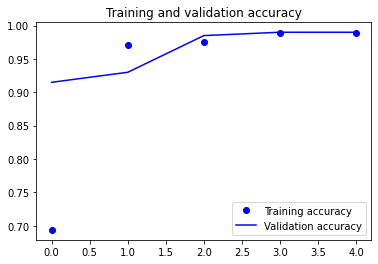

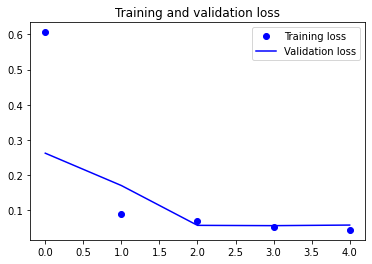

In [21]:
# Plot performance of the model over task=0
accuracy = mul_head_train.history['head_0_accuracy']
val_accuracy = mul_head_train.history['val_head_0_accuracy']
loss = mul_head_train.history['loss']
val_loss = mul_head_train.history['val_head_0_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Without EWC

In [22]:
# For all the tasks other than the 0 task:
for task in range(1,num_tasks):
  
  print("\n\nWorking on task {}\n\n".format(task))

  # Compile the model training only the relevan head w.r.t. the task we are dealing with
  mul_head.compile(loss={'head_{}'.format(task): cross_entropy},
                  optimizer='adam',
                  metrics={'head_{}'.format(task): "accuracy"})

  # Define the scale parameter needed to remap the labels into {0,1} during each task
  scale=2*task

  # Build data pipelines for training and validation set
  training_set_task=train_data[task*2].concatenate(train_data[task*2+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale)).prefetch(tf.data.AUTOTUNE)
  validation_set_task=valid_data[task*2].concatenate(valid_data[task*2+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale)).prefetch(tf.data.AUTOTUNE)

  # Train the model
  mul_head_train = mul_head.fit(training_set_task,
                                epochs=EPOCHS,
                                validation_data=validation_set_task)
  
heads_accuracy_no_EWC=[]
for task in range(num_tasks):
  heads_accuracy_no_EWC.append(check_test_acc(mul_head,task,test_data,normalize_pixels_scale_labels))

print()
print("Performances over test sets after the sequential training\nTask 0 --> Task 1 --> Task 2 --> Task 3 \nAre (no EWC):\n\n")
for task in range(num_tasks):
  print("Accuracy of the model over test set for task {} is:".format(task), np.round(heads_accuracy_no_EWC[task],4)),



Working on task 1


Epoch 1/5


28/28 [==============================] - 2s 59ms/step - loss: 0.2880 - head_1_loss: 0.2880 - head_1_accuracy: 0.8913 - val_loss: 0.3017 - val_head_1_loss: 0.3017 - val_head_1_accuracy: 0.8977
Epoch 2/5
28/28 [==============================] - 1s 37ms/step - loss: 0.2118 - head_1_loss: 0.2118 - head_1_accuracy: 0.9199 - val_loss: 0.3631 - val_head_1_loss: 0.3631 - val_head_1_accuracy: 0.8920
Epoch 3/5
28/28 [==============================] - 1s 38ms/step - loss: 0.2063 - head_1_loss: 0.2063 - head_1_accuracy: 0.9130 - val_loss: 0.3721 - val_head_1_loss: 0.3721 - val_head_1_accuracy: 0.8750
Epoch 4/5
28/28 [==============================] - 1s 38ms/step - loss: 0.2048 - head_1_loss: 0.2048 - head_1_accuracy: 0.9153 - val_loss: 0.2796 - val_head_1_loss: 0.2796 - val_head_1_accuracy: 0.9034
Epoch 5/5
28/28 [==============================] - 1s 37ms/step - loss: 0.1537 - head_1_loss: 0.1537 - head_1_accuracy: 0.9371 - val_loss: 0.2588 - val_head_1_loss: 0.2588 - val_head_1_accuracy: 0.8920


28/28 [==============================] - 2s 62ms/step - loss: 0.5162 - head_2_loss: 0.5162 - head_2_accuracy: 0.7128 - val_loss: 0.3137 - val_head_2_loss: 0.3137 - val_head_2_accuracy: 0.8901
Epoch 2/5
28/28 [==============================] - 1s 38ms/step - loss: 0.1964 - head_2_loss: 0.1964 - head_2_accuracy: 0.9291 - val_loss: 0.1986 - val_head_2_loss: 0.1986 - val_head_2_accuracy: 0.9319
Epoch 3/5
28/28 [==============================] - 1s 38ms/step - loss: 0.1205 - head_2_loss: 0.1205 - head_2_accuracy: 0.9588 - val_loss: 0.1598 - val_head_2_loss: 0.1598 - val_head_2_accuracy: 0.9319
Epoch 4/5
28/28 [==============================] - 1s 38ms/step - loss: 0.1041 - head_2_loss: 0.1041 - head_2_accuracy: 0.9657 - val_loss: 0.1477 - val_head_2_loss: 0.1477 - val_head_2_accuracy: 0.9319
Epoch 5/5
28/28 [==============================] - 1s 38ms/step - loss: 0.0911 - head_2_loss: 0.0911 - head_2_accuracy: 0.9668 - val_loss: 0.1377 - val_head_2_loss: 0.1377 - val_head_2_accuracy: 0.9476


28/28 [==============================] - 2s 62ms/step - loss: 0.3528 - head_3_loss: 0.3528 - head_3_accuracy: 0.8677 - val_loss: 0.4739 - val_head_3_loss: 0.4739 - val_head_3_accuracy: 0.8579
Epoch 2/5
28/28 [==============================] - 1s 37ms/step - loss: 0.2103 - head_3_loss: 0.2103 - head_3_accuracy: 0.9407 - val_loss: 0.2610 - val_head_3_loss: 0.2610 - val_head_3_accuracy: 0.8798
Epoch 3/5
28/28 [==============================] - 1s 38ms/step - loss: 0.1893 - head_3_loss: 0.1893 - head_3_accuracy: 0.9418 - val_loss: 0.1419 - val_head_3_loss: 0.1419 - val_head_3_accuracy: 0.9672
Epoch 4/5
28/28 [==============================] - 1s 38ms/step - loss: 0.1432 - head_3_loss: 0.1432 - head_3_accuracy: 0.9578 - val_loss: 0.3062 - val_head_3_loss: 0.3062 - val_head_3_accuracy: 0.8689
Epoch 5/5
28/28 [==============================] - 1s 38ms/step - loss: 0.1166 - head_3_loss: 0.1166 - head_3_accuracy: 0.9704 - val_loss: 0.2207 - val_head_3_loss: 0.2207 - val_head_3_accuracy: 0.8962


### With EWC

In [25]:
# For all the tasks other than the 0 task:
# RECALL: if coming from "Without EWC regularization" cell runs,
# remember to reinitialize the model and retrain on task 0 before!
for task in range(1,num_tasks):
  
  print("\n\nWorking on task {}\n\n".format(task))

  # Compile the model training only the relevan head w.r.t. the task we are dealing with
  mul_head.compile(loss={'head_{}'.format(task): EWC_loss(F,task_prev_param,Lambda=100)},
                  optimizer='adam',
                  metrics={'head_{}'.format(task): "accuracy"})

  # Define the scale parameter needed to remap the labels into {0,1} during each task
  scale=2*task

  # Build data pipelines for training and validation set
  training_set_task=train_data[task*2].concatenate(train_data[task*2+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale)).prefetch(tf.data.AUTOTUNE)
  validation_set_task=valid_data[task*2].concatenate(valid_data[task*2+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale)).prefetch(tf.data.AUTOTUNE)

  # Train the model
  mul_head_train = mul_head.fit(training_set_task,
                                epochs=EPOCHS,
                                validation_data=validation_set_task)

  
  # Copy the model parameters at the end of training. They will be used by EWC regularization during 
  # the training over the next task
  task_prev_param=[tf.identity(mul_head.trainable_variables[layer]) for layer in range(len(mul_head.trainable_variables))]

  # Compute the new Fisher matrixes (using the gradients computed after last task)
  # and update the Fisher matrixes by summing old Fisher matrixes with the new ones
  new_F= compute_fisher_matrix(mul_head, validation_set_task, batch_size=250,task_id=task)
  for layer in range(len(F)):
    F[layer]=F[layer]+new_F[layer]

# Compute performances of the fully trained (with EWC)  model in each task
heads_accuracy_EWC=[]
for task in range(num_tasks):
  heads_accuracy_EWC.append(check_test_acc(mul_head,task,test_data,normalize_pixels_scale_labels))

print()
print("Performances over test sets after the sequential training\nTask 0 --> Task 1 --> Task 2 --> Task 3\nAre (with EWC):\n\n")
for task in range(num_tasks):
  print("Accuracy of the model over test set for task {} is:".format(task), np.round(heads_accuracy_EWC[task],4))



Working on task 1


Epoch 1/5
28/28 [==============================] - 3s 52ms/step - loss: 10.0325 - head_1_loss: 10.0325 - head_1_accuracy: 0.7700 - val_loss: 2.5196 - val_head_1_loss: 2.5196 - val_head_1_accuracy: 0.8580
Epoch 2/5
28/28 [==============================] - 1s 38ms/step - loss: 0.6946 - head_1_loss: 0.6946 - head_1_accuracy: 0.9153 - val_loss: 0.2833 - val_head_1_loss: 0.2833 - val_head_1_accuracy: 0.8864
Epoch 3/5
28/28 [==============================] - 1s 38ms/step - loss: 0.2217 - head_1_loss: 0.2217 - head_1_accuracy: 0.9291 - val_loss: 0.2663 - val_head_1_loss: 0.2663 - val_head_1_accuracy: 0.8864
Epoch 4/5
28/28 [==============================] - 1s 37ms/step - loss: 0.2090 - head_1_loss: 0.2090 - head_1_accuracy: 0.9222 - val_loss: 0.2800 - val_head_1_loss: 0.2800 - val_head_1_accuracy: 0.8864
Epoch 5/5
28/28 [==============================] - 1s 43ms/step - loss: 0.2172 - head_1_loss: 0.2172 - head_1_accuracy: 0.9279 - val_loss: 0.2939 - val_head_1_loss: 0.2



Working on task 1


28/28 [==============================] - 3s 56ms/step - loss: 10.2438 - head_1_loss: 10.2438 - head_1_accuracy: 0.9302 - val_loss: 0.6624 - val_head_1_loss: 0.6624 - val_head_1_accuracy: 0.8750


Working on task 2


28/28 [==============================] - 3s 53ms/step - loss: 9.2668 - head_2_loss: 9.2668 - head_2_accuracy: 0.9199 - val_loss: 0.3785 - val_head_2_loss: 0.3785 - val_head_2_accuracy: 0.9476


Working on task 3


28/28 [==============================] - 3s 57ms/step - loss: 12.0237 - head_3_loss: 12.0237 - head_3_accuracy: 0.7172 - val_loss: 0.7173 - val_head_3_loss: 0.7173 - val_head_3_accuracy: 0.8251


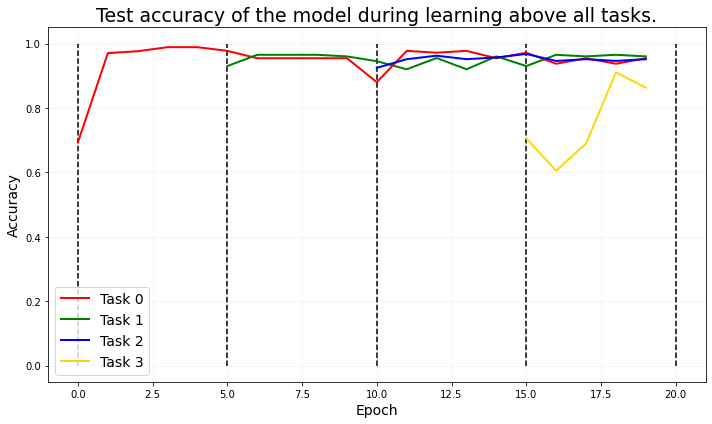

In [26]:
# Define list of lists to store the performance of each head during the training executed for all the tasks
accuracies=[[] for task in range(num_tasks)]

# For all the tasks other than the 0 task:
for task in range(1,num_tasks):
  
  print("\n\nWorking on task {}\n\n".format(task))

  scale=2*task

  # For each of the epochs we want to train each head with:
  for epoch in range(EPOCHS):

    # Compile the model training only the relevan head w.r.t. the task we are dealing with
    mul_head.compile(loss={'head_{}'.format(task): EWC_loss(F,task_prev_param,Lambda=100)},
                    optimizer='adam',
                    metrics={'head_{}'.format(task): "accuracy"})

    # Build data pipelines for training and validation set
    training_set_task=train_data[task*2].concatenate(train_data[task*2+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale)).prefetch(tf.data.AUTOTUNE)
    validation_set_task=valid_data[task*2].concatenate(valid_data[task*2+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale)).prefetch(tf.data.AUTOTUNE)

    # Train the model for a single epoch
    mul_head_train = mul_head.fit(training_set_task,
                                  epochs=1,
                                  validation_data=validation_set_task)

    # Assess the performance of the previously trained heads during current training epoch by epoch
    for intra_task in range(task+1):
      accuracies[intra_task].append(check_test_acc(mul_head,intra_task,test_data,normalize_pixels_scale_labels))
 
  # Copy the model parameters at the end of training. They will be used by EWC regularization during 
  # the training over the next task
  task_prev_param=[tf.identity(mul_head.trainable_variables[layer]) for layer in range(len(mul_head.trainable_variables))]

  # Compute the new Fisher matrixes (using the gradients computed after last task)
  # and update the Fisher matrixes by summing old Fisher matrixes with the new ones
  new_F= compute_fisher_matrix(mul_head, validation_set_task, batch_size=256,task_id=task)
  for layer in range(len(F)):
    F[layer]=F[layer]+new_F[layer]

# Append learning accuracy trend obtained during learning on task 0
accuracies[0]=accuracy+accuracies[0]

# Perform the plot
training_phases=np.array(range(0,EPOCHS*EPOCHS,EPOCHS))
colors=["red","green","blue", "gold"]
plt.figure(figsize=(10,6), tight_layout=True)
for task in range(num_tasks):
  plt.plot(range(EPOCHS*task,len(accuracies[task])+EPOCHS*task), accuracies[task], color=colors[task],linewidth=2, label='Task {}'.format(task))
plt.vlines(training_phases,0,1,linestyles="dashed")
plt.xlabel('Epoch',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.title(('Test accuracy of the model during learning above all tasks.'),fontsize=19)
plt.legend(fontsize=14,loc="lower left")
plt.grid(axis='x', color='0.95')
plt.grid(axis='y', color='0.95')
plt.savefig('intertask_accuracies.png')
plt.show()